# PART-1


In [ ]:
import zipfile
import os

# Specify the path to your ZIP file
zip_file_path = '/content/NSL_KDD-master.zip'  # Replace 'your_dataset.zip' with the name of your file

# Path where the files will be extracted
extract_path = '/content/nsl_kdd/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")


Files extracted to: /content/nsl_kdd/


In [ ]:
!ls /content/nsl_kdd/NSL_KDD-master


'20 Percent Training Set.csv'   KDDTrain+_20Percent.txt
'Attack Types.csv'	        KDDTrain+.csv
'Field Names.csv'	        KDDTrain+.txt
'Field Names.docx'	       'Original NSL KDD Zip.zip'
 KDDTest-21.txt		        ReadMe.txt
 KDDTest+.csv		       'Small Training Set.csv'
 KDDTest+.txt


In [ ]:
import pandas as pd

field_file = '/content/nsl_kdd/NSL_KDD-master/Field Names.csv'
field_names_df = pd.read_csv(field_file, header=None)

print(field_names_df)


                              0           1
0                      duration  continuous
1                 protocol_type    symbolic
2                       service    symbolic
3                          flag    symbolic
4                     src_bytes  continuous
5                     dst_bytes  continuous
6                          land  continuous
7                wrong_fragment  continuous
8                        urgent  continuous
9                           hot  continuous
10            num_failed_logins  continuous
11                    logged_in  continuous
12              num_compromised  continuous
13                   root_shell  continuous
14                 su_attempted  continuous
15                     num_root  continuous
16           num_file_creations  continuous
17                   num_shells  continuous
18             num_access_files  continuous
19            num_outbound_cmds  continuous
20                is_host_login  continuous
21               is_guest_login 

In [ ]:
col_names = field_names_df[0].tolist()
col_names += ['label', 'difficulty']
print(f"Number of columns: {len(col_names)}")



Number of columns: 43


In [ ]:
train_file = '/content/nsl_kdd/NSL_KDD-master/KDDTrain+.csv'
df = pd.read_csv(train_file, header=None, names=col_names)

print(df.shape)
df.head()


(125973, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
df_normal = df[df['label'] == 'normal']
print(f"Normal samples: {df_normal.shape}")


Normal samples: (67343, 43)


In [ ]:
# Count normal samples
normal_count = (df['label'] == 'normal').sum()

# Count other samples
attack_count = (df['label'] != 'normal').sum()

print(f"Normal samples: {normal_count}")
print(f"Attack samples: {attack_count}")


Normal samples: 67343
Attack samples: 58630


In [ ]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['protocol_type', 'service', 'flag']
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  # save encoders if needed for test set


In [ ]:
from sklearn.preprocessing import StandardScaler

num_cols = [col for col in df.columns if col not in cat_cols + ['label', 'difficulty']]

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [ ]:
X_train = df[df['label'] == 'normal'][cat_cols + num_cols].values
print(f"X_train shape: {X_train.shape}")


X_train shape: (67343, 41)


# PART-2


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Suppose df is already preprocessed (encoding + scaling done)
# And you already filtered normal samples as X_train (numpy array)

# Convert to torch tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)

# Define simple Dataset
class NSLKDDDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

# Instantiate dataset + dataloader
dataset = NSLKDDDataset(X_train_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [ ]:
num_steps = 100
beta_start = 1e-4
beta_end = 0.025
betas = torch.linspace(beta_start, beta_end, num_steps)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)


In [ ]:
def forward_diffusion_sample(x0, t, alphas_cumprod):
    sqrt_alphas_cumprod_t = alphas_cumprod[t].sqrt().unsqueeze(1)
    sqrt_one_minus_alphas_cumprod_t = (1 - alphas_cumprod[t]).sqrt().unsqueeze(1)

    noise = torch.randn_like(x0)
    xt = sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_alphas_cumprod_t * noise
    return xt, noise


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class AdvancedDenoiseNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=340, n_layers=5, emb_dim=64):
        super().__init__()
        self.input_dim = input_dim

        # timestep embedding layer
        self.time_embed = nn.Sequential(
            nn.Linear(1, emb_dim),
            nn.SiLU(),
            nn.Linear(emb_dim, emb_dim)
        )

        # input projection
        self.input_proj = nn.Linear(input_dim + emb_dim, hidden_dim)

        # deep residual layers
        self.res_layers = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(hidden_dim),
                nn.Linear(hidden_dim, hidden_dim),
                nn.SiLU(),
                nn.Dropout(0.1),
                nn.Linear(hidden_dim, hidden_dim),
            ) for _ in range(n_layers)
        ])

        # output projection
        self.out_proj = nn.Linear(hidden_dim, input_dim)

        # STEP 5: output normalization layer (new layer added)
        self.output_norm = nn.LayerNorm(input_dim)

        # STEP 6: global skip projection (to match input_dim to output_dim if needed)
        self.skip_proj = nn.Identity()  # if input_dim == input_dim, no projection needed
        # If you want explicit projection (can swap Identity to Linear):
        # self.skip_proj = nn.Linear(input_dim, input_dim)

    def forward(self, x, t):
        # embed t
        t = t.float().unsqueeze(1) / num_steps
        t_emb = self.time_embed(t)

        # concatenate timestep embedding
        x_in = torch.cat([x, t_emb], dim=1)
        x_proj = self.input_proj(x_in)

        # pass through residual layers
        h = x_proj
        for layer in self.res_layers:
            h_res = layer(h)
            h = h + h_res  # residual connection

        # project to output
        output = self.out_proj(h)


        return output


In [ ]:
input_dim = X_train_tensor.shape[1]
model = AdvancedDenoiseNet(input_dim)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

loss_fn = nn.MSELoss()


In [ ]:
from tqdm import tqdm

num_epochs = 30

for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in tqdm(dataloader):
        batch = batch

        t = torch.randint(0, num_steps, (batch.shape[0],), device=batch.device)

        x_noisy, noise = forward_diffusion_sample(batch, t, alphas_cumprod)

        pred_noise = model(x_noisy, t)

        loss = loss_fn(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # gradient clipping
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()
    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


100%|██████████| 1053/1053 [00:22<00:00, 47.20it/s]


Epoch 1/30, Loss: 0.3289


100%|██████████| 1053/1053 [00:20<00:00, 50.51it/s]


Epoch 2/30, Loss: 0.2176


100%|██████████| 1053/1053 [00:20<00:00, 52.50it/s]


Epoch 3/30, Loss: 0.2015


100%|██████████| 1053/1053 [00:21<00:00, 49.27it/s]


Epoch 4/30, Loss: 0.1855


100%|██████████| 1053/1053 [00:21<00:00, 48.30it/s]


Epoch 5/30, Loss: 0.1759


100%|██████████| 1053/1053 [00:20<00:00, 51.73it/s]


Epoch 6/30, Loss: 0.1708


100%|██████████| 1053/1053 [00:20<00:00, 51.04it/s]


Epoch 7/30, Loss: 0.1699


100%|██████████| 1053/1053 [00:20<00:00, 50.48it/s]


Epoch 8/30, Loss: 0.1504


100%|██████████| 1053/1053 [00:20<00:00, 51.52it/s]


Epoch 9/30, Loss: 0.1599


100%|██████████| 1053/1053 [00:20<00:00, 51.49it/s]


Epoch 10/30, Loss: 0.1480


100%|██████████| 1053/1053 [00:21<00:00, 50.05it/s]


Epoch 11/30, Loss: 0.1393


100%|██████████| 1053/1053 [00:20<00:00, 50.38it/s]


Epoch 12/30, Loss: 0.1565


100%|██████████| 1053/1053 [00:20<00:00, 52.09it/s]


Epoch 13/30, Loss: 0.1319


100%|██████████| 1053/1053 [00:20<00:00, 51.12it/s]


Epoch 14/30, Loss: 0.1360


100%|██████████| 1053/1053 [00:20<00:00, 50.55it/s]


Epoch 15/30, Loss: 0.1216


100%|██████████| 1053/1053 [00:23<00:00, 44.00it/s]


Epoch 16/30, Loss: 0.1306


100%|██████████| 1053/1053 [00:21<00:00, 49.85it/s]


Epoch 17/30, Loss: 0.1151


100%|██████████| 1053/1053 [00:21<00:00, 49.06it/s]


Epoch 18/30, Loss: 0.1221


100%|██████████| 1053/1053 [00:20<00:00, 50.58it/s]


Epoch 19/30, Loss: 0.1088


100%|██████████| 1053/1053 [00:19<00:00, 52.86it/s]


Epoch 20/30, Loss: 0.1060


100%|██████████| 1053/1053 [00:20<00:00, 50.37it/s]


Epoch 21/30, Loss: 0.1044


100%|██████████| 1053/1053 [00:20<00:00, 50.43it/s]


Epoch 22/30, Loss: 0.0942


100%|██████████| 1053/1053 [00:20<00:00, 52.16it/s]


Epoch 23/30, Loss: 0.0933


100%|██████████| 1053/1053 [00:21<00:00, 50.11it/s]


Epoch 24/30, Loss: 0.0894


100%|██████████| 1053/1053 [00:20<00:00, 50.36it/s]


Epoch 25/30, Loss: 0.0866


100%|██████████| 1053/1053 [00:20<00:00, 52.22it/s]


Epoch 26/30, Loss: 0.0850


100%|██████████| 1053/1053 [00:20<00:00, 50.68it/s]


Epoch 27/30, Loss: 0.0827


100%|██████████| 1053/1053 [00:21<00:00, 49.05it/s]


Epoch 28/30, Loss: 0.0809


100%|██████████| 1053/1053 [00:20<00:00, 51.55it/s]


Epoch 29/30, Loss: 0.0809


100%|██████████| 1053/1053 [00:20<00:00, 51.77it/s]

Epoch 30/30, Loss: 0.0800


# PART-3


In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load test CSV
test_file = '/content/nsl_kdd/NSL_KDD-master/KDDTest+.csv'
df_test = pd.read_csv(test_file, header=None, names=col_names)

# Encode categorical columns (using saved encoders from train)
for col in cat_cols:
    df_test[col] = le_dict[col].transform(df_test[col])

# Scale numerical columns
df_test[num_cols] = scaler.transform(df_test[num_cols])

# Extract ground-truth labels
y_true = df_test['label'].values
y_bin = (y_true != 'normal').astype(int)  # binary anomaly labels

# Extract features
X_test = df_test[cat_cols + num_cols].values
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


In [ ]:
#anamoly function
def predict_x0_from_xt_xt_noise(x_t, t, pred_noise, alphas_cumprod):
    """
    Reconstruct x0 estimate from noisy input x_t and predicted noise at step t.
    """
    sqrt_recip_alpha_cumprod = (1. / alphas_cumprod[t]).sqrt().unsqueeze(1)
    sqrt_one_minus_alpha_cumprod = (1 - alphas_cumprod[t]).sqrt().unsqueeze(1)
    x0_pred = sqrt_recip_alpha_cumprod * (x_t - sqrt_one_minus_alpha_cumprod * pred_noise)
    return x0_pred




In [ ]:
def evaluate_reconstruction_errors_full(model, X_tensor, alphas_cumprod, num_steps, num_t_samples=20, batch_size=64):
    """
    Evaluate per-sample reconstruction errors over multiple diffusion steps.

    Returns:
        mean_errors: [num_samples]
        var_errors: [num_samples]
        errors_matrix: [num_samples x num_t_samples]
    """
    model.eval()
    errors_per_sample = []

    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            x_batch = X_tensor[i:i+batch_size]
            sample_errors = []

            for _ in range(num_t_samples):
                t = torch.randint(0, num_steps, (x_batch.shape[0],), device=x_batch.device)
                x_noisy, _ = forward_diffusion_sample(x_batch, t, alphas_cumprod)
                pred_noise = model(x_noisy, t)
                x0_pred = predict_x0_from_xt_xt_noise(x_noisy, t, pred_noise, alphas_cumprod)
                mse = ((x0_pred - x_batch) ** 2).mean(dim=1)  # mean over features
                sample_errors.append(mse.cpu().numpy())

            sample_errors = np.stack(sample_errors, axis=1)  # shape: [batch_size x num_t_samples]
            errors_per_sample.extend(sample_errors.tolist())

    errors_matrix = np.array(errors_per_sample)  # shape: [num_samples x num_t_samples]
    mean_errors = errors_matrix.mean(axis=1)
    var_errors = errors_matrix.var(axis=1)

    return mean_errors, var_errors, errors_matrix


In [ ]:
def compute_multivariate_mahalanobis(test_mean, test_var, train_mean, train_var):
    """
    Compute Mahalanobis anomaly scores in 2D space (mean error, variance error).

    Formula:
        D_M = sqrt( (x-mu)^T Σ^{-1} (x-mu) )
    """
    from scipy.linalg import inv
    import numpy as np

    mu = np.array([train_mean.mean(), train_var.mean()])
    cov_matrix = np.cov(np.stack([train_mean, train_var], axis=0))
    inv_cov = inv(cov_matrix + 1e-8 * np.eye(2))  # add epsilon for stability

    test_points = np.stack([test_mean, test_var], axis=1)  # [num_samples x 2]
    diff = test_points - mu  # [num_samples x 2]

    mahal_scores = np.einsum('ij,jk,ik->i', diff, inv_cov, diff)
    return mahal_scores


In [ ]:
def evaluate_anomaly_metrics(y_true_bin, anomaly_scores):
    from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve, confusion_matrix
    import matplotlib.pyplot as plt
    import numpy as np

    roc_auc = roc_auc_score(y_true_bin, anomaly_scores)
    precision, recall, thresholds = precision_recall_curve(y_true_bin, anomaly_scores)
    pr_auc = auc(recall, precision)
    fpr, tpr, _ = roc_curve(y_true_bin, anomaly_scores)

    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")

    plt.figure(figsize=(16,4))

    # ROC Curve
    plt.subplot(1,3,1)
    plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc:.4f}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()

    # Precision-Recall Curve
    plt.subplot(1,3,2)
    plt.plot(recall, precision, label=f"PR AUC={pr_auc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    # FIXED Anomaly Score Histogram: log-transform scores
    log_scores = np.log10(anomaly_scores + 1e-8)  # avoid log(0)
    plt.subplot(1,3,3)
    plt.hist(log_scores[y_true_bin==0], bins=50, alpha=0.5, label="Normal")
    plt.hist(log_scores[y_true_bin==1], bins=50, alpha=0.5, label="Attack")
    plt.xlabel("Log10(Anomaly Score)")
    plt.ylabel("Count")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Best threshold (F1)
    f1s = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_thresh = thresholds[np.argmax(f1s)]
    print(f"Best threshold: {best_thresh:.4f}")

    y_pred = (anomaly_scores >= best_thresh).astype(int)
    cm = confusion_matrix(y_true_bin, y_pred)
    print("Confusion Matrix:\n", cm)

    return cm, best_thresh


In [ ]:
# Step 1: compute train reconstruction errors
train_mean_errors, train_var_errors, _ = evaluate_reconstruction_errors_full(model, X_train_tensor, alphas_cumprod, num_steps)

# Step 2: compute test reconstruction errors
test_mean_errors, test_var_errors, _ = evaluate_reconstruction_errors_full(model, X_test_tensor, alphas_cumprod, num_steps)

# Step 3: compute Mahalanobis anomaly scores
mahal_scores = compute_multivariate_mahalanobis(test_mean_errors, test_var_errors, train_mean_errors, train_var_errors)


ROC AUC: 0.8947
PR AUC: 0.9152


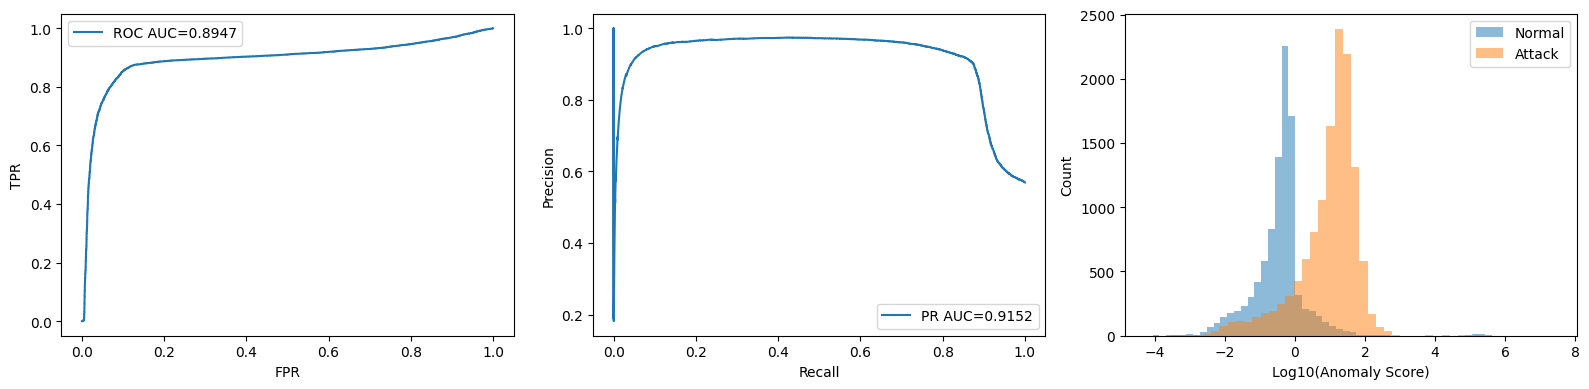

Best threshold: 1.0723
Confusion Matrix:
 [[ 8539  1171]
 [ 1644 11189]]


In [ ]:
#confusion matrix
conf_matrix, best_thresh = evaluate_anomaly_metrics(y_bin, mahal_scores)

# PART-4

In [ ]:
def threshold_optimization(y_true_bin, anomaly_scores, manual_thresh=None, show_metrics_at=[0.5, 1.0, 1.5]):
    """
    Find optimal threshold, plot precision/recall/F1, evaluate manual threshold.

    Args:
        y_true_bin (array): Binary true labels (0 normal, 1 anomaly)
        anomaly_scores (array): Model anomaly scores
        manual_thresh (float): Optional manual threshold override
        show_metrics_at (list): Optional list of thresholds to print metrics

    Returns:
        Confusion matrix, selected threshold
    """
    from sklearn.metrics import precision_recall_curve, confusion_matrix, f1_score, precision_score, recall_score
    import numpy as np
    import matplotlib.pyplot as plt

    # Compute precision, recall, thresholds
    precision, recall, thresholds = precision_recall_curve(y_true_bin, anomaly_scores)
    f1s = 2 * (precision * recall) / (precision + recall + 1e-8)

    # Find threshold with max F1
    max_f1_idx = np.argmax(f1s)
    best_thresh = thresholds[max_f1_idx]

    print(f"\n Best threshold (F1-max): {best_thresh:.4f}")
    print(f" Max F1 Score: {f1s[max_f1_idx]:.4f}")

    # Plot Precision, Recall, F1 vs Threshold (centered around best_thresh)
    plt.figure(figsize=(8,4))
    plt.plot(thresholds, precision[:-1], label='Precision', linewidth=1.5)
    plt.plot(thresholds, recall[:-1], label='Recall', linewidth=1.5)
    plt.plot(thresholds, f1s[:-1], label='F1 Score', linewidth=1.5)
    plt.axvline(best_thresh, color='red', linestyle='--', linewidth=1.2, label=f'Best Thresh: {best_thresh:.4f}')

    #  Center plot around best_thresh
    window = 50  # adjust this as needed (smaller or larger)
    left_limit = max(0, best_thresh - window)
    right_limit = best_thresh + window
    plt.xlim(left_limit, right_limit)

    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Threshold Optimization (Centered on Best Threshold)")
    plt.legend(fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout(pad=1.0)
    plt.show()

    # Print optional metrics at specified thresholds
    for t in show_metrics_at:
        y_pred_temp = (anomaly_scores >= t).astype(int)
        prec_t = precision_score(y_true_bin, y_pred_temp)
        rec_t = recall_score(y_true_bin, y_pred_temp)
        f1_t = f1_score(y_true_bin, y_pred_temp)
        print(f"Metrics at threshold {t:.2f}: Precision={prec_t:.4f}, Recall={rec_t:.4f}, F1={f1_t:.4f}")

    # Select threshold
    if manual_thresh is not None:
        print(f"\n Manual threshold override: {manual_thresh:.4f}")
        selected_thresh = manual_thresh
    else:
        selected_thresh = best_thresh

    # Final prediction + confusion matrix
    y_pred = (anomaly_scores >= selected_thresh).astype(int)
    cm = confusion_matrix(y_true_bin, y_pred)

    print(f"\n📝 Confusion Matrix at threshold {selected_thresh:.4f}:")
    print(cm)

    return cm, selected_thresh



 Best threshold (F1-max): 1.0723
 Max F1 Score: 0.8883


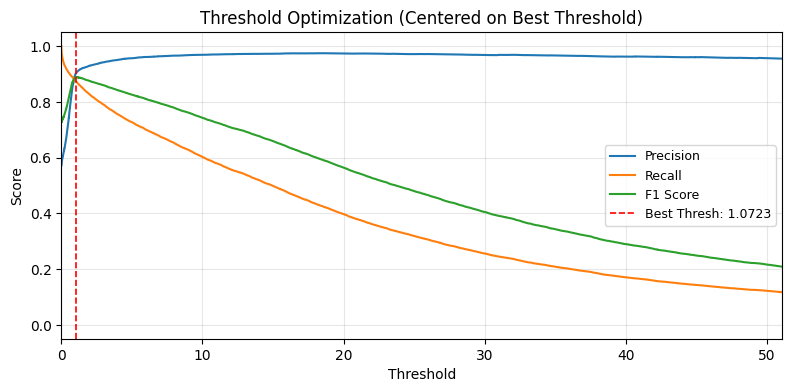

Metrics at threshold 0.50: Precision=0.7281, Recall=0.9066, F1=0.8076
Metrics at threshold 1.00: Precision=0.8990, Recall=0.8756, F1=0.8871
Metrics at threshold 1.50: Precision=0.9208, Recall=0.8499, F1=0.8839

📝 Confusion Matrix at threshold 1.0723:
[[ 8539  1171]
 [ 1644 11189]]


In [ ]:
cm, selected_thresh = threshold_optimization(y_bin, mahal_scores)

In [ ]:
def threshold_confusion_matrix_multiple(y_true_bin, anomaly_scores, manual_thresholds):
    """
    Evaluate confusion matrix at multiple manual thresholds.

    Args:
        y_true_bin (array): binary labels (0 normal, 1 anomaly)
        anomaly_scores (array): anomaly scores
        manual_thresholds (list): list of thresholds to evaluate

    Returns:
        dict of threshold: confusion_matrix
    """
    from sklearn.metrics import confusion_matrix

    cm_dict = {}

    for thresh in manual_thresholds:
        y_pred = (anomaly_scores >= thresh).astype(int)
        cm = confusion_matrix(y_true_bin, y_pred)
        cm_dict[thresh] = cm
        print(f"\nConfusion Matrix at threshold {thresh:.4f}:")
        print(cm)

    return cm_dict


In [ ]:
manual_thresholds = [0.5, 0.8, 1.0, 1.2, 1.5]
cm_dict = threshold_confusion_matrix_multiple(y_bin, mahal_scores, manual_thresholds)



Confusion Matrix at threshold 0.5000:
[[ 5364  4346]
 [ 1198 11635]]

Confusion Matrix at threshold 0.8000:
[[ 7772  1938]
 [ 1442 11391]]

Confusion Matrix at threshold 1.0000:
[[ 8447  1263]
 [ 1596 11237]]

Confusion Matrix at threshold 1.2000:
[[ 8627  1083]
 [ 1741 11092]]

Confusion Matrix at threshold 1.5000:
[[ 8772   938]
 [ 1926 10907]]


# PART-5

In [ ]:
def compute_per_feature_errors(model, X_tensor, alphas_cumprod, num_steps, num_t_samples=20, batch_size=64):
    """
    Returns: per_sample_errors: shape [num_samples, num_features]
    """
    model.eval()
    feature_errors = []

    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            x_batch = X_tensor[i:i+batch_size]
            sample_feature_errors = []
            for _ in range(num_t_samples):
                t = torch.randint(0, num_steps, (x_batch.shape[0],), device=x_batch.device)
                x_noisy, _ = forward_diffusion_sample(x_batch, t, alphas_cumprod)
                pred_noise = model(x_noisy, t)
                x0_pred = predict_x0_from_xt_xt_noise(x_noisy, t, pred_noise, alphas_cumprod)

                mse_per_feature = ((x0_pred - x_batch) ** 2)  # shape [batch_size, num_features]
                sample_feature_errors.append(mse_per_feature.cpu().numpy())

            # Average across num_t_samples
            sample_feature_errors = np.mean(np.stack(sample_feature_errors, axis=0), axis=0)  # [batch_size, num_features]
            feature_errors.append(sample_feature_errors)

    per_sample_errors = np.vstack(feature_errors)  # [num_samples, num_features]
    return per_sample_errors


In [ ]:
# Compute per-feature reconstruction errors for test set
test_feature_errors = compute_per_feature_errors(model, X_test_tensor, alphas_cumprod, num_steps)


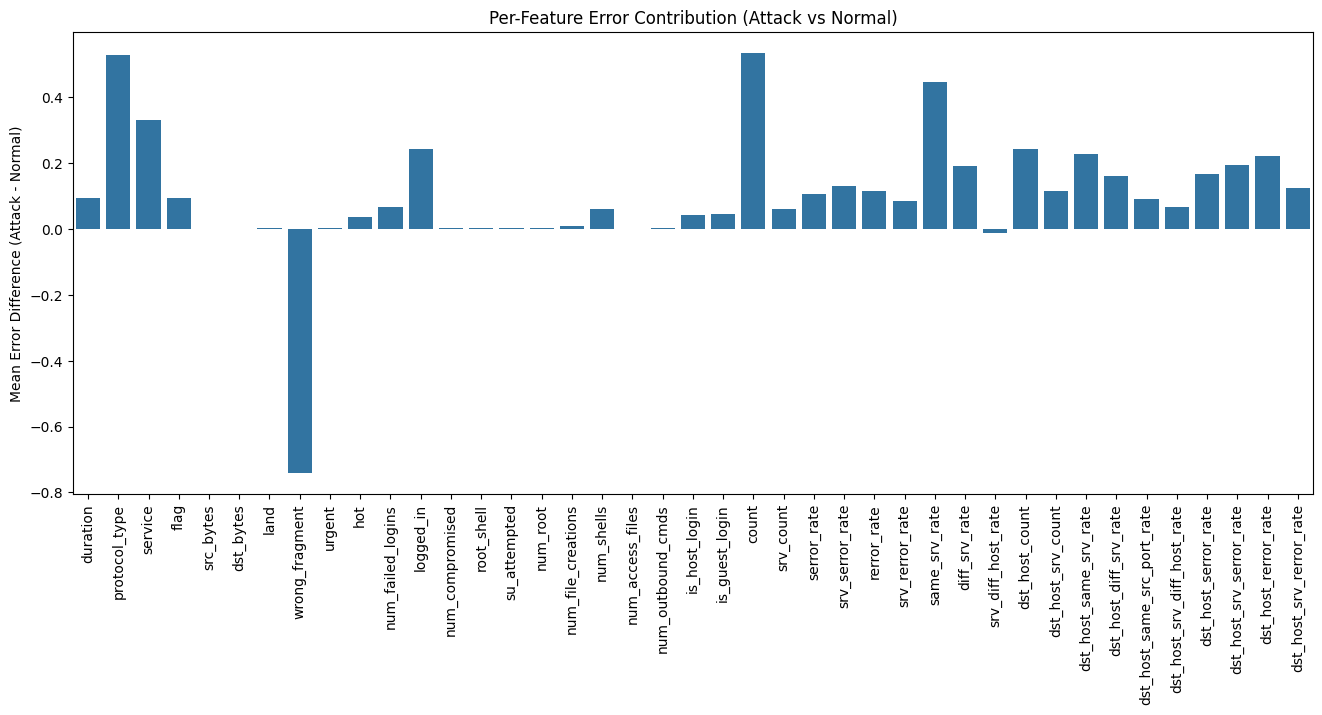

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Separate normal and attack indices
normal_idx = (y_bin == 0)
attack_idx = (y_bin == 1)

# Plot mean error per feature for normal vs attack
mean_normal_errors = test_feature_errors[normal_idx].mean(axis=0)
mean_attack_errors = test_feature_errors[attack_idx].mean(axis=0)

plt.figure(figsize=(16,6))
sns.barplot(x=col_names[:-2], y=mean_attack_errors - mean_normal_errors)
plt.xticks(rotation=90)
plt.ylabel("Mean Error Difference (Attack - Normal)")
plt.title("Per-Feature Error Contribution (Attack vs Normal)")
plt.show()


In [ ]:
# Rank features by absolute error difference
feature_importance = np.abs(mean_attack_errors - mean_normal_errors)
sorted_idx = np.argsort(feature_importance)[::-1]

print("\nTop 10 important features:")
for idx in sorted_idx[:10]:
    print(f"{col_names[idx]}: error diff = {feature_importance[idx]:.4f}")



Top 10 important features:
wrong_fragment: error diff = 0.7408
count: error diff = 0.5337
protocol_type: error diff = 0.5286
same_srv_rate: error diff = 0.4459
service: error diff = 0.3307
logged_in: error diff = 0.2432
dst_host_count: error diff = 0.2425
dst_host_same_srv_rate: error diff = 0.2261
dst_host_rerror_rate: error diff = 0.2210
dst_host_srv_serror_rate: error diff = 0.1922


# PART-6

In [ ]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

ae_model = Autoencoder(input_dim=X_train_tensor.shape[1])
ae_optimizer = torch.optim.Adam(ae_model.parameters(), lr=1e-3)
loss_fn_ae = nn.MSELoss()

num_epochs_ae = 30

for epoch in range(num_epochs_ae):
    epoch_loss = 0
    for i in range(0, X_train_tensor.shape[0], 64):
        batch = X_train_tensor[i:i+64]
        recon = ae_model(batch)
        loss = loss_fn_ae(recon, batch)

        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / (X_train_tensor.shape[0] // 64)
    print(f"AE Epoch {epoch+1}/{num_epochs_ae}, Loss: {avg_loss:.4f}")


AE Epoch 1/30, Loss: 1.2587
AE Epoch 2/30, Loss: 0.2499
AE Epoch 3/30, Loss: 0.1728
AE Epoch 4/30, Loss: 0.1255
AE Epoch 5/30, Loss: 0.0951
AE Epoch 6/30, Loss: 0.0847
AE Epoch 7/30, Loss: 0.0764
AE Epoch 8/30, Loss: 0.0425
AE Epoch 9/30, Loss: 0.0788
AE Epoch 10/30, Loss: 0.0709
AE Epoch 11/30, Loss: 0.0612
AE Epoch 12/30, Loss: 0.0359
AE Epoch 13/30, Loss: 0.0655
AE Epoch 14/30, Loss: 0.0419
AE Epoch 15/30, Loss: 0.0493
AE Epoch 16/30, Loss: 0.0395
AE Epoch 17/30, Loss: 0.0557
AE Epoch 18/30, Loss: 0.0472
AE Epoch 19/30, Loss: 0.0388
AE Epoch 20/30, Loss: 0.0464
AE Epoch 21/30, Loss: 0.0393
AE Epoch 22/30, Loss: 0.0463
AE Epoch 23/30, Loss: 0.0321
AE Epoch 24/30, Loss: 0.0452
AE Epoch 25/30, Loss: 0.0302
AE Epoch 26/30, Loss: 0.0323
AE Epoch 27/30, Loss: 0.0327
AE Epoch 28/30, Loss: 0.0399
AE Epoch 29/30, Loss: 0.0261
AE Epoch 30/30, Loss: 0.0245


ROC AUC: 0.9510
PR AUC: 0.9453


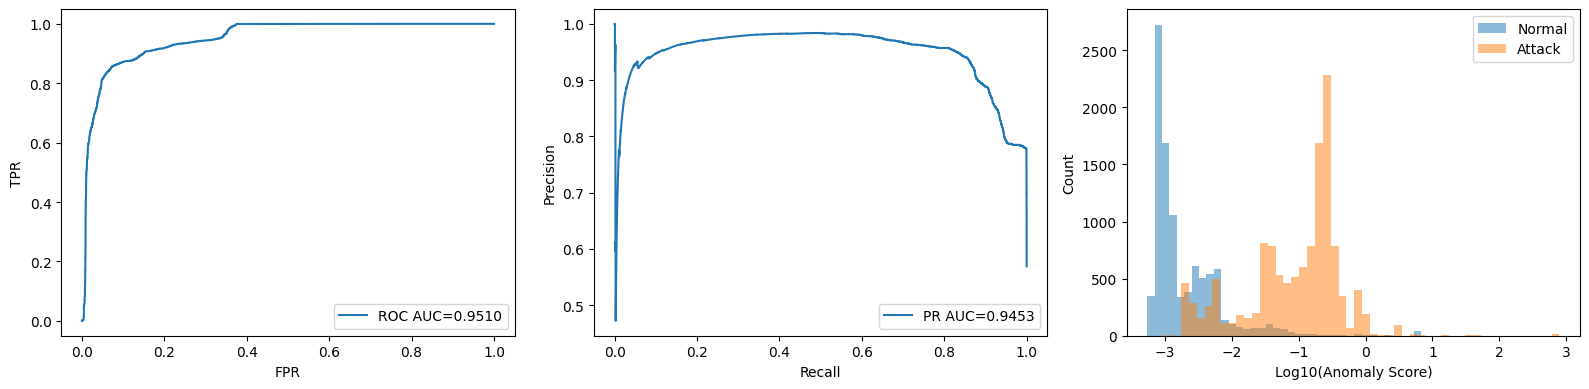

Best threshold: 0.0094
Confusion Matrix:
 [[ 8947   763]
 [ 1789 11044]]


In [ ]:
ae_model.eval()
with torch.no_grad():
    recon_test = ae_model(X_test_tensor)
    ae_errors = ((X_test_tensor - recon_test) ** 2).mean(dim=1).cpu().numpy()

conf_matrix_ae, _ = evaluate_anomaly_metrics(y_bin, ae_errors)


ROC AUC: 0.8909
PR AUC: 0.8549


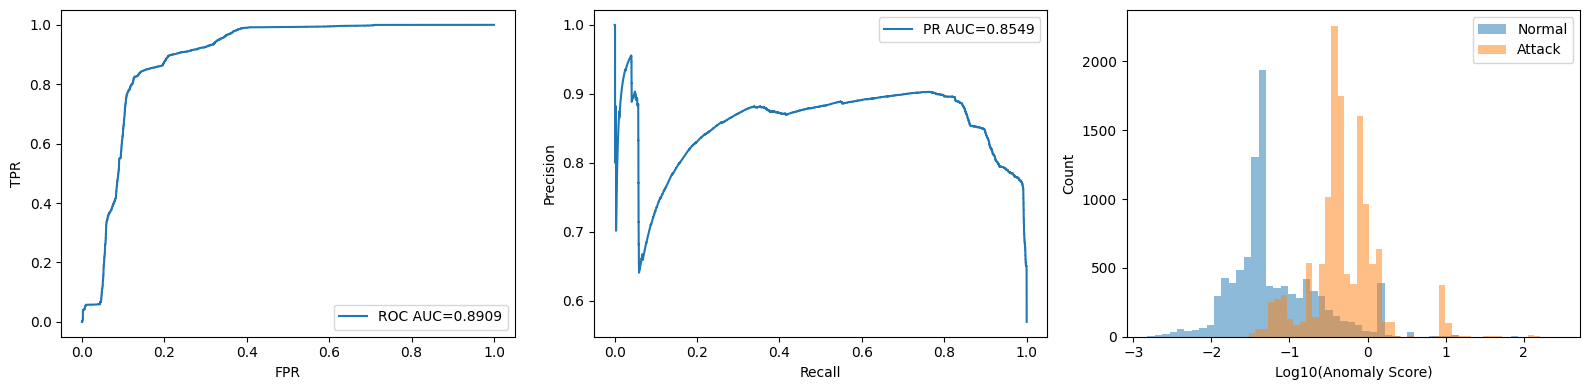

Best threshold: 0.1691
Confusion Matrix:
 [[ 7640  2070]
 [ 1307 11526]]


In [ ]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=0.95)  # retain 95% variance
pca.fit(X_train)

X_test_pca = pca.transform(X_test)
X_test_recon = pca.inverse_transform(X_test_pca)
pca_errors = np.mean((X_test - X_test_recon) ** 2, axis=1)

conf_matrix_pca, _ = evaluate_anomaly_metrics(y_bin, pca_errors)

ROC AUC: 0.9390
PR AUC: 0.9525


<ipython-input-21-168beb36a9db>:31: RuntimeWarning: invalid value encountered in log10
  log_scores = np.log10(anomaly_scores + 1e-8)  # avoid log(0)


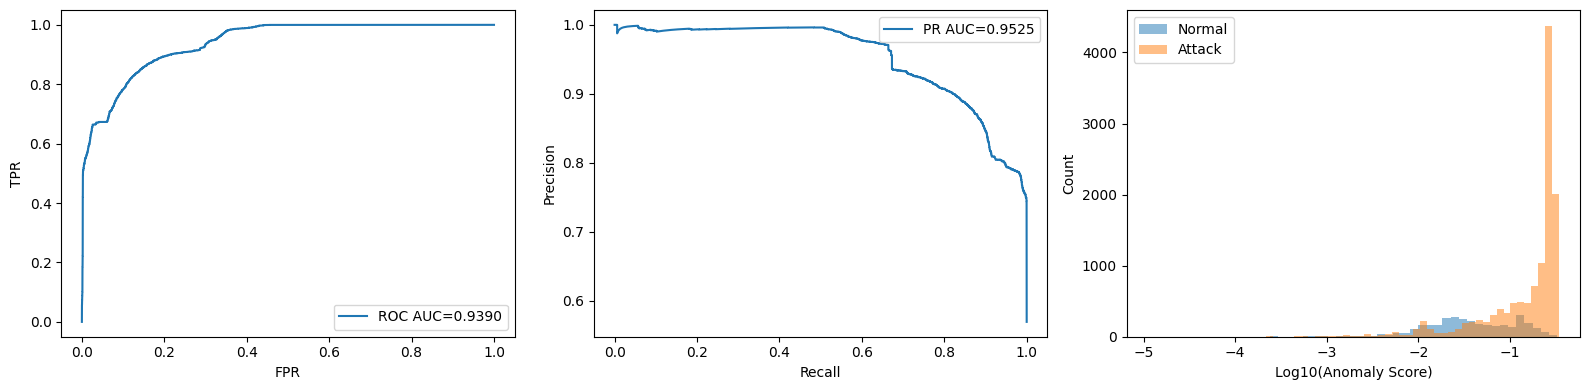

Best threshold: 0.0319
Confusion Matrix:
 [[ 7898  1812]
 [ 1441 11392]]


In [ ]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest on normal training data
iso_forest = IsolationForest(contamination=0.5, random_state=42)
iso_forest.fit(X_train)

# Get anomaly scores on test set
iso_scores = -iso_forest.decision_function(X_test)  # flip sign so higher = more anomalous

# Evaluate using your existing function
conf_matrix_iso, _ = evaluate_anomaly_metrics(y_bin, iso_scores)


In [ ]:
print("\n--- Baseline Confusion Matrices ---")
print("Diffusion Confusion Matrix:\n", conf_matrix)
print("Autoencoder Confusion Matrix:\n", conf_matrix_ae)
print("PCA Confusion Matrix:\n", conf_matrix_pca)
print("Isolation Forest Confusion Matrix:\n", conf_matrix_iso)



--- Baseline Confusion Matrices ---
Diffusion Confusion Matrix:
 [[ 8539  1171]
 [ 1644 11189]]
Autoencoder Confusion Matrix:
 [[ 8947   763]
 [ 1789 11044]]
PCA Confusion Matrix:
 [[ 7640  2070]
 [ 1307 11526]]
Isolation Forest Confusion Matrix:
 [[ 7898  1812]
 [ 1441 11392]]
